# Image Generation via Generative Adversarial Networks

## import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## load data

In [2]:
directory_data  = './'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))
real            = data['real_images']

In [3]:
print('size of real data:', real.shape)

size of real data: (4324, 32, 32)


## plot data

In [4]:
def plot_image(title, image):
    
    nRow = 3
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
   
    for r in range(nRow): 
        for c in range(nCol):
            k = c * 300 + r * nCol * 300
            axes[r, c].imshow(image[k], cmap='gray')

    plt.tight_layout()
    plt.show()

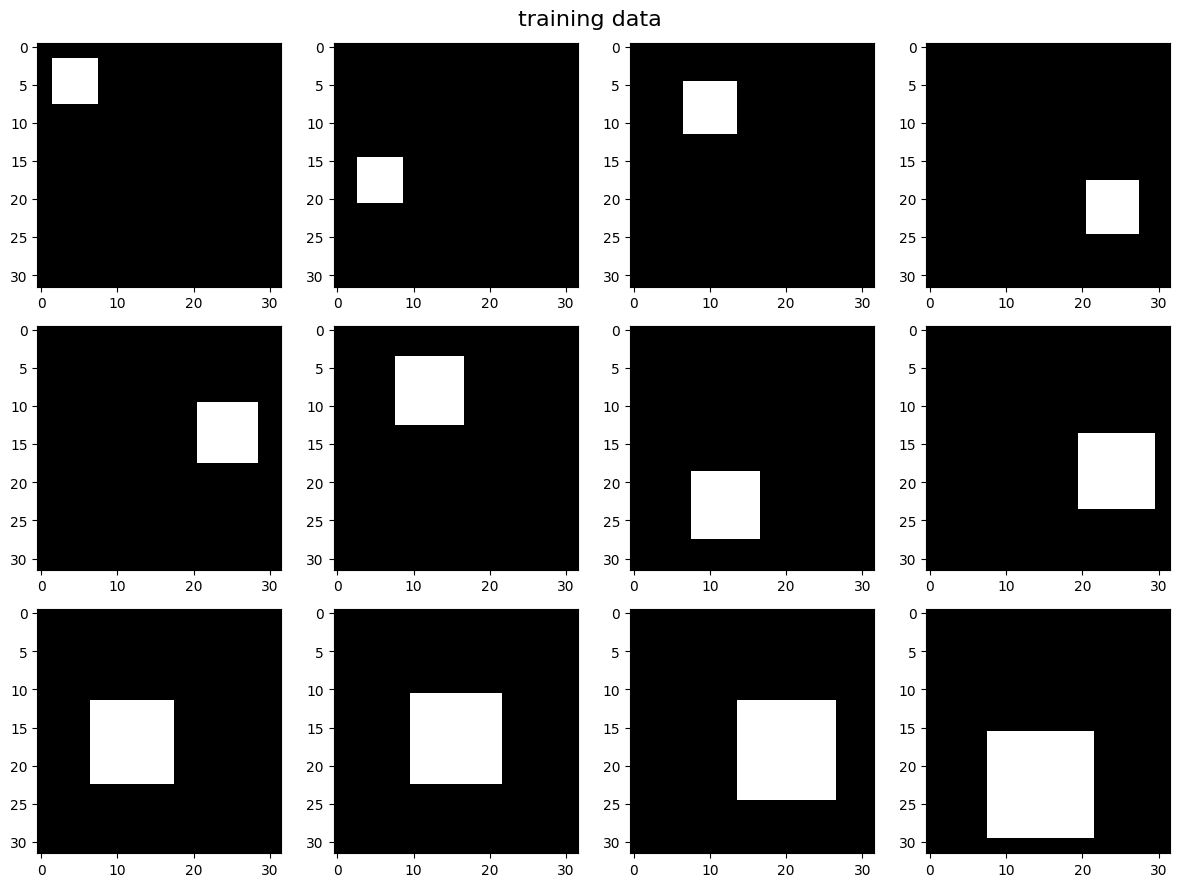

In [5]:
plot_image('training data', real)

## custom data loader for the PyTorch framework

In [6]:
class dataset(Dataset):
    
    def __init__(self, image):
        
        self.image = image
    
    def __getitem__(self, index):
        
        sample  = self.image[index]
        sample  = torch.FloatTensor(sample).unsqueeze(dim=0)

        return (sample)
    
    def __len__(self):

        number_image = len(self.image)

        return (number_image)

## setting device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [8]:
print(device)

mps


In [9]:
# random seed
import random
random.seed(20184757)
np.random.seed(20184757)
torch.manual_seed(20184757)
torch.cuda.manual_seed(20184757)
torch.cuda.manual_seed_all(20184757)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## construct datasets and dataloaders 

In [10]:
size_minibatch  = 32
dim_latent      = 64 # input latent vector fixed dimension 

dataset_real    = dataset(real)
dataloader_real = torch.utils.data.DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

## neural networks 

In [11]:
class Discriminator(nn.Module): 
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256, out_features=512, bias=True),
            nn.LeakyReLU(0.2),
            
#             nn.Linear(in_features=64, out_features=32, bias=True),
#             nn.LeakyReLU(0.2),
            
#             nn.Linear(in_features=32, out_features=16, bias=True),
#             nn.LeakyReLU(0.2),
            
#             nn.Linear(in_features=16, out_features=8, bias=True),
#             nn.LeakyReLU(0.2),
            
            nn.Linear(in_features=512, out_features=1, bias=True),
        )
        
        self.network = nn.Sequential(
            self.feature,
            nn.Flatten(),
            self.classifier,
        )
        
    def forward(self, x):
        out = self.network(x)
        return out


In [12]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.network = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=dim_latent, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.network(x)
        return out

## build network

In [13]:
generator       = Generator().to(device)
discriminator   = Discriminator().to(device)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.001, weight_decay=0.0001)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.001, weight_decay=0.0001)

## compute the prediction

In [14]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the accuracy

In [15]:
def compute_bounding_mask(prediction_binary):
    
    bounding_mask = torch.zeros_like(prediction_binary)
    
    for i in range(prediction_binary.shape[0]):
        prediction = prediction_binary[i]
        (idx_row, idx_col) = torch.nonzero(prediction, as_tuple=True)
        
        if len(idx_row) > 0: 
            idx_row_min = idx_row.min()
            idx_row_max = idx_row.max()
        
            idx_col_min = idx_col.min()
            idx_col_max = idx_col.max()
    
            bounding_mask[i, idx_row_min:idx_row_max+1, idx_col_min:idx_col_max+1] = 1 
    
    return bounding_mask

In [16]:
def compute_accuracy(prediction):

    binary      = (prediction >= 0.5)
    mask        = compute_bounding_mask(binary)
    
    intersection = (binary & mask).float().sum((1, 2))
    union        = (binary | mask).float().sum((1, 2))

    eps         = 1e-8
    correct     = (intersection + eps) / (union + eps)
    accuracy    = correct.mean() * 100.0
    accuracy    = accuracy.cpu() 
    
    return accuracy

## train

In [17]:
def train(generator, discriminator, dataloader):
    
    for index_batch, (real) in enumerate(dataloader):
        real        = real.to(device)
        size_batch  = len(real)
        latent      = torch.randn(size_batch, dim_latent, device=device)
        latent      = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()
        
        optimizer_generator.zero_grad()
        fake = compute_prediction(generator, latent)
#         loss_image = nn.BCELoss()(fake, real)
        prediction_fake = compute_prediction(discriminator, fake)
        label_fake = torch.ones_like(prediction_fake)
        loss_label = nn.BCEWithLogitsLoss()(prediction_fake, label_fake)
#         loss_generator = 0.1 * loss_image + loss_label
        loss_generator = loss_label
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()
        
        optimizer_discriminator.zero_grad()
        fake = compute_prediction(generator, latent)
        prediction_real = compute_prediction(discriminator, real)
        prediction_fake = compute_prediction(discriminator, fake)
        loss_real = nn.BCEWithLogitsLoss()(prediction_real, torch.ones((size_batch, 1), device=device))
        loss_fake = nn.BCEWithLogitsLoss()(prediction_fake, torch.zeros((size_batch, 1), device=device))
        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        

## test

In [18]:
def test(generator, latent):
    
    generator.eval()
    
    prediction  = generator(latent)
    prediction  = prediction.squeeze(axis=1)
    accuracy    = compute_accuracy(prediction)
    
    return accuracy

## training epoch

In [19]:
number_epoch    = 10
accuracy_epoch  = np.zeros(number_epoch)

num_latent_test = 100
latent_test = torch.randn(num_latent_test, dim_latent, device=device)
latent_test = torch.reshape(latent_test, [num_latent_test, dim_latent, 1, 1])

for i in tqdm(range(number_epoch)):
    train(generator, discriminator, dataloader_real)
    accuracy = test(generator, latent_test)
    accuracy_epoch[i] = accuracy

  0%|                                                    | 0/10 [00:00<?, ?it/s]/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_83920/474554764.py:7: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  (idx_row, idx_col) = torch.nonzero(prediction, as_tuple=True)
100%|███████████████████████████████████████████| 10/10 [01:41<00:00, 10.12s/it]


---

# functions for presenting the results

---

In [20]:
def function_result_01():

    num_latent_visualize = 16

    latent_visualize = torch.randn(num_latent_visualize, dim_latent, device=device)
    latent_visualize = torch.reshape(latent_visualize, [num_latent_visualize, dim_latent, 1, 1]) 

    prediction = compute_prediction(generator, latent_visualize)
    prediction = prediction.squeeze(axis=1)
    prediction_binary = (prediction >= 0.5)
    bounding_mask = compute_bounding_mask(prediction_binary)
        
    fake = prediction.detach().cpu()
    mask = bounding_mask.detach().cpu()

    nRow = 4
    nCol = 4 
    size = 3 
    
    title = 'fake image'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(fake[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()
    
    title = 'bounding mask'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(mask[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)
                        
    plt.tight_layout()
    plt.show()

In [21]:
def function_result_02():

    title           = 'accuracy'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    
    plt.plot(accuracy_epoch)
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [22]:
def function_result_03():

    print('final accuracy = %9.8f' % (accuracy_epoch[-1]))

---

## results

---


################################################################################
#
# RESULT # 01
#
################################################################################



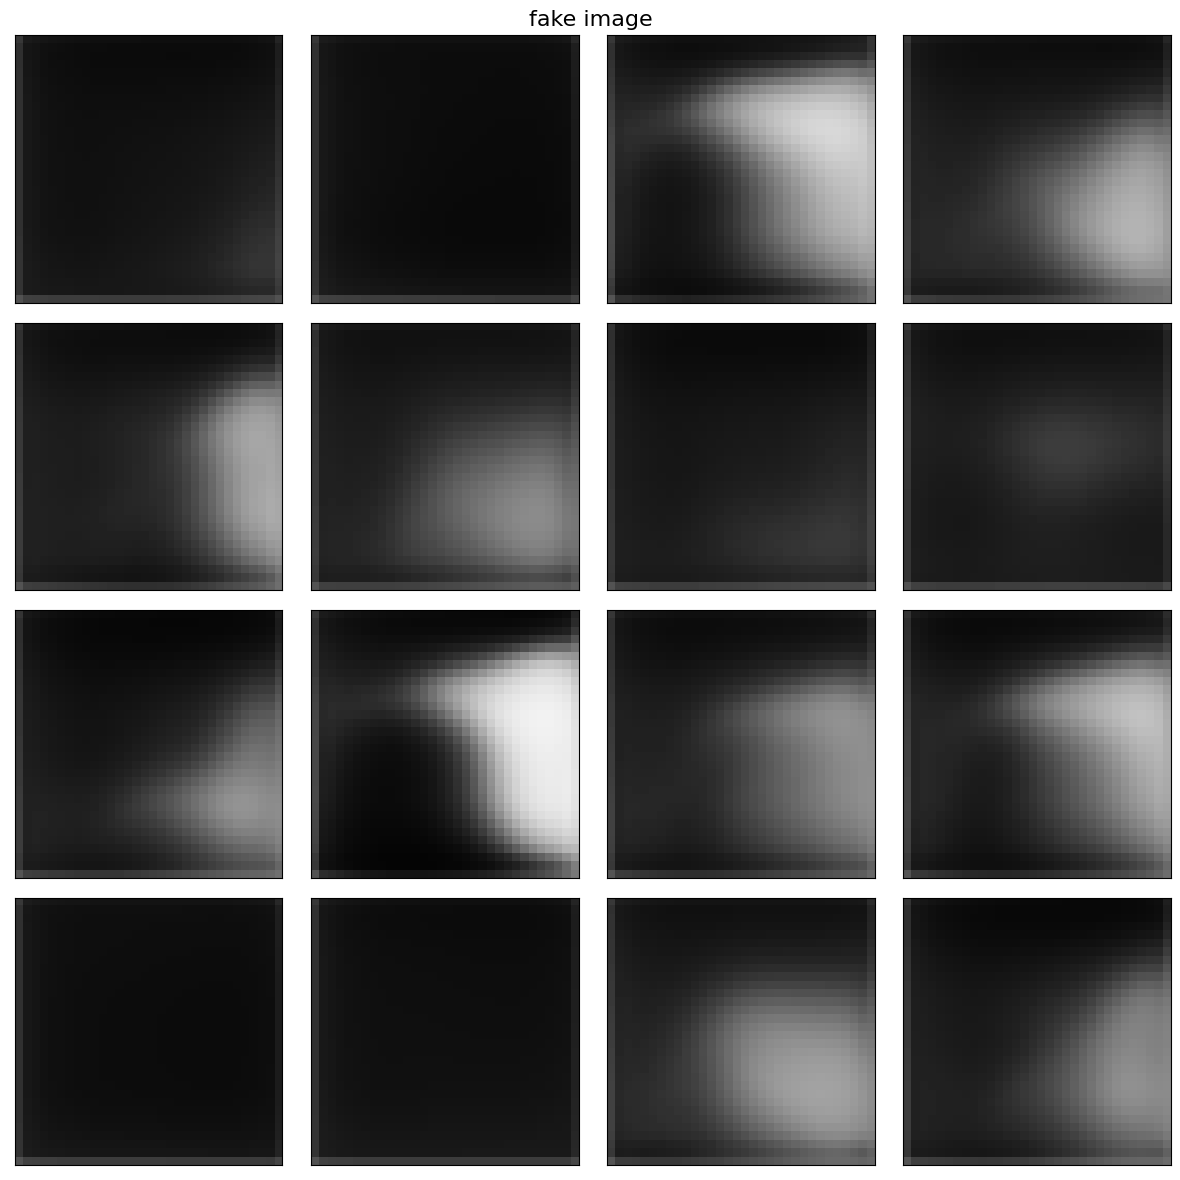

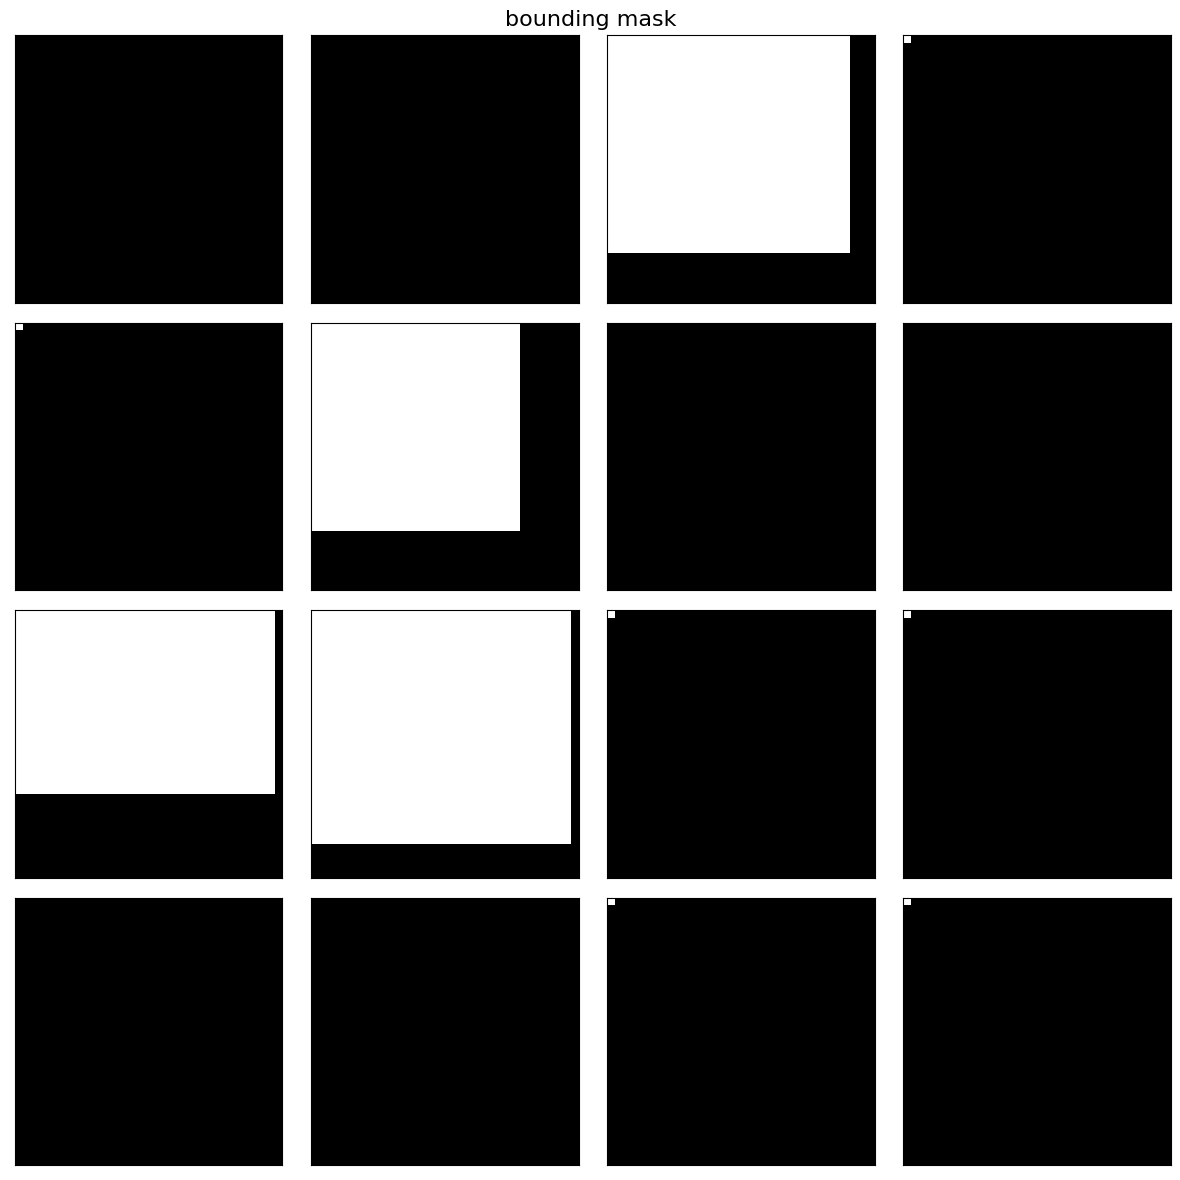


################################################################################
#
# RESULT # 02
#
################################################################################



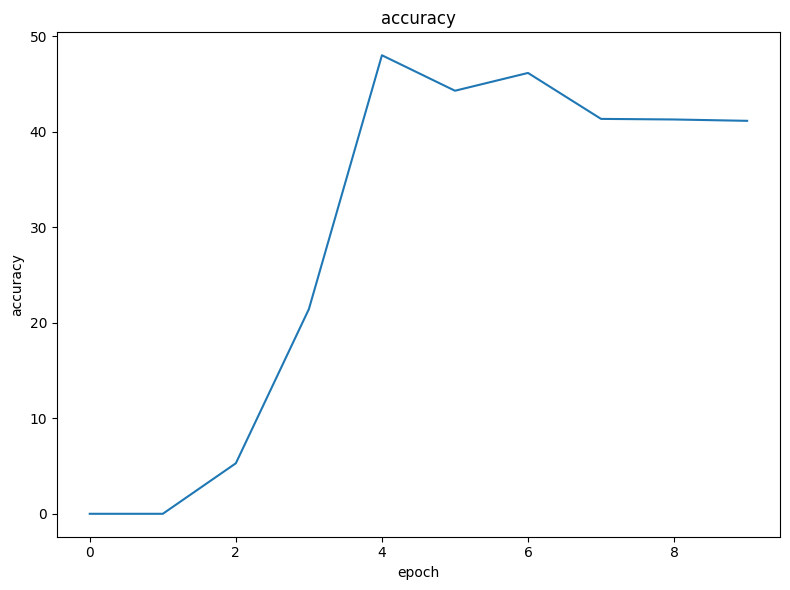


################################################################################
#
# RESULT # 03
#
################################################################################

final accuracy = 41.16366577


In [23]:
number_result = 3

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)